In [1]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs



In [2]:
def construct_season_mask(dates, season):
    """Generate a DataArray that has True/1 in the specified season, False/0 otherwise."""
    try:
        assert season in ("DJF", "JJA", "SON", "MAM")
    except AssertionError as error:
        print("[ERROR] You have to specify which season to do.")
    month = dates.dt.month
    if season == "DJF":
        season_mask = (month == 12) | (month == 1) | (month == 2)
    elif season == "MAM":
        sason_mask = (month == 3) | (month == 4) | (month == 5)
    elif season == "JJA":
        season_mask = (month == 6) | (month == 7) | (month == 8)
    elif season == "SON":
        season_mask = (month == 9) | (month == 10) | (month == 11)
    else:
        raise ValueError("[ERROR in construct_season_mask] The season specification failed for some reason.")
    return season_mask



In [3]:
def get_avg_number_by_season(dataset, season):
    """Calculate the average number of events in a specified season."""
    start_dates = dataset['initial_date'][1::,:,:]
    season_mask = construct_season_mask(start_dates, season)
    # number of events in each season
    year = start_dates.dt.year
    earliest_year = year.min().values.item()
    latest_year = year.max().values.item()
    number_years = latest_year - earliest_year
    return season_mask.sum(dim='events') / number_years



In [23]:
def get_avg_number_by_season_and_duration(dataset, season, dmin=6):
    """Calculate the average number of events in a specified season."""
    start_dates = dataset['initial_date'][1::,:,:]
    d = dataset['duration'][1::,:,:] # SKIP "event" 0 b/c it is the non-events
    
    long_events_arr = np.where(d >= dmin, start_dates, np.datetime64('NaT'))
    long_events = start_dates.copy()
    long_events.values = long_events_arr

    season_mask = construct_season_mask(long_events, season)
    # number of events in each season
    year = start_dates.dt.year
    earliest_year = year.min().values.item()
    latest_year = year.max().values.item()
    number_years = latest_year - earliest_year
    return season_mask.sum(dim='events') / number_years


In [4]:

def get_avg_duration_by_season(dataset, season=None):
    assert 'initial_date' in dataset
    assert 'duration' in dataset
    # Load variables from dataset
    d = dataset['duration'][1::,:,:] # SKIP "event" 0 b/c it is the non-events
    # construct a boolean mask, True in season
    mask = construct_season_mask(dataset['initial_date'][1::,:,:], season)
    # Filter duration
    duration_in_season = np.where(mask, d, np.nan)
    # this line turns the numpy array into a xarray.DataArray
    duration_in_season = xr.DataArray(duration_in_season, coords=d.coords, dims=d.dims)
    # NOTE: we have filtered duration to only include events that start in a specified season,
    #       The average duration is then just the average value of the filtered data.
    return duration_in_season.mean(dim='events')


In [5]:
stem = "/project/amp/brianpm/TemperatureExtremes/Derived/"
obsfil = "CPC_tmax_90pct_event_attributes_c20191118.nc"
mdlfil = "f.e13.FAMIPC5CN.ne30_ne30.beta17.TREFMXAV.90pct_event_attributes_c20191118.nc"

In [6]:
ds = xr.open_dataset(stem+obsfil)
mdl_ds = xr.open_dataset(stem+mdlfil)

In [7]:

obs_djf_avg_num = get_avg_number_by_season(ds, "DJF")
obs_jja_avg_num = get_avg_number_by_season(ds, "JJA")

obs_djf_avg_dur = get_avg_duration_by_season(ds, "DJF")
obs_jja_avg_dur = get_avg_duration_by_season(ds, "JJA")


/project/amp/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/project/amp/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [8]:
mdl_djf_avg_num = get_avg_number_by_season(mdl_ds, "DJF")
mdl_jja_avg_num = get_avg_number_by_season(mdl_ds, "JJA")

mdl_djf_avg_dur = get_avg_duration_by_season(mdl_ds, "DJF")
mdl_jja_avg_dur = get_avg_duration_by_season(mdl_ds, "JJA")


In [24]:
# min duration 6d
obs_djf_avg_long = get_avg_number_by_season_and_duration(ds, "DJF")
obs_jja_avg_long = get_avg_number_by_season_and_duration(ds, "JJA")

mdl_djf_avg_long = get_avg_number_by_season_and_duration(mdl_ds, "DJF")
mdl_jja_avg_long = get_avg_number_by_season_and_duration(mdl_ds, "JJA")


In [9]:
lons, lats = np.meshgrid(ds['lon'], ds['lat'])

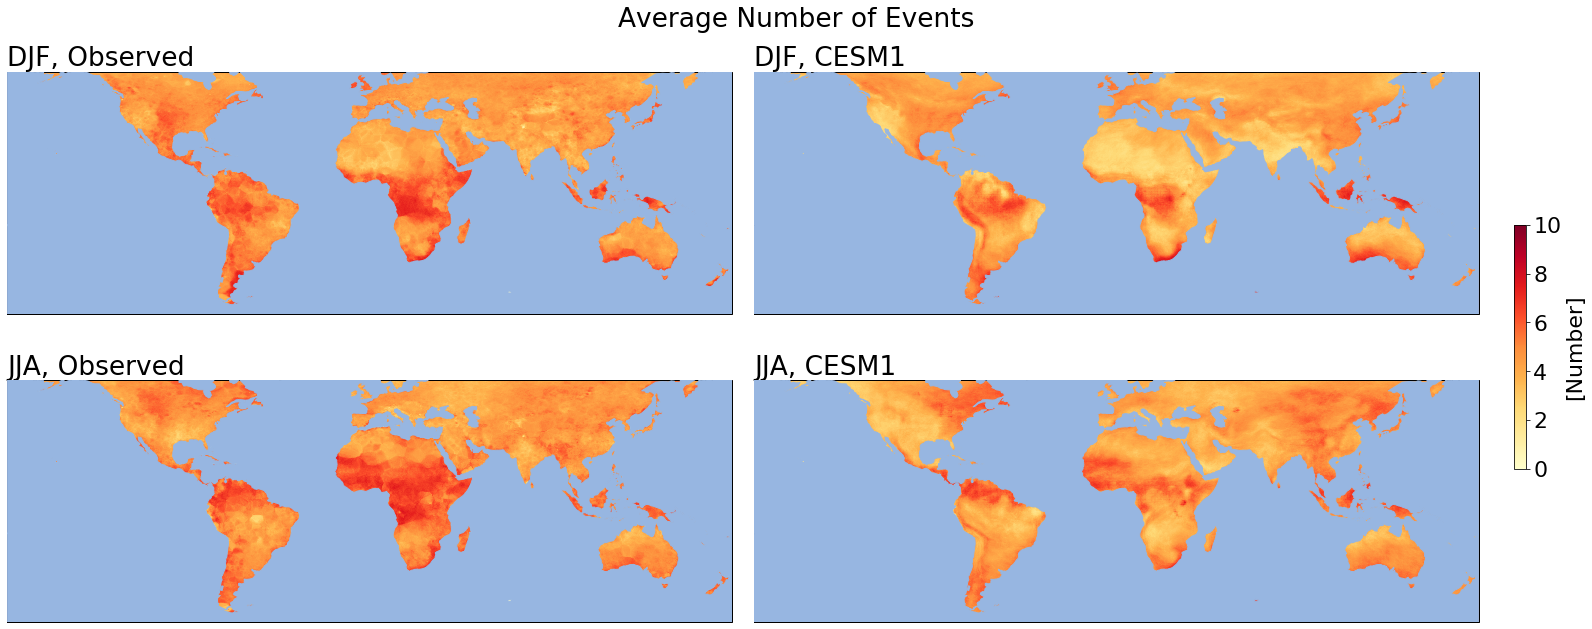

In [12]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(22,9), ncols=2, nrows=2, subplot_kw={'projection':ccrs.PlateCarree()}, constrained_layout=True)
aa = ax.ravel()
imgs = [aa[i].pcolormesh(lons, 
                         lats, 
                         v, 
                         transform=ccrs.PlateCarree(), 
                         cmap='YlOrRd', vmin=0.0, vmax=10.0) 
        for i, v in enumerate([obs_djf_avg_num, mdl_djf_avg_num, obs_jja_avg_num, mdl_jja_avg_num])]
[a.add_feature(cartopy.feature.OCEAN, zorder=100) for a in aa]
[a.set_extent([-180, 180,-60, 60]) for a in aa]
aa[0].set_title("DJF, Observed", loc='left')
aa[1].set_title("DJF, CESM1", loc='left')
aa[2].set_title("JJA, Observed", loc='left')
aa[3].set_title("JJA, CESM1", loc='left')
cb = fig.colorbar(imgs[0], ax=aa, shrink=0.4)
cb.set_label("[Number]")
fig.suptitle("Average Number of Events")
fig.savefig("/project/amp/brianpm/ams_poster_fig4.png", bbox_inches='tight')

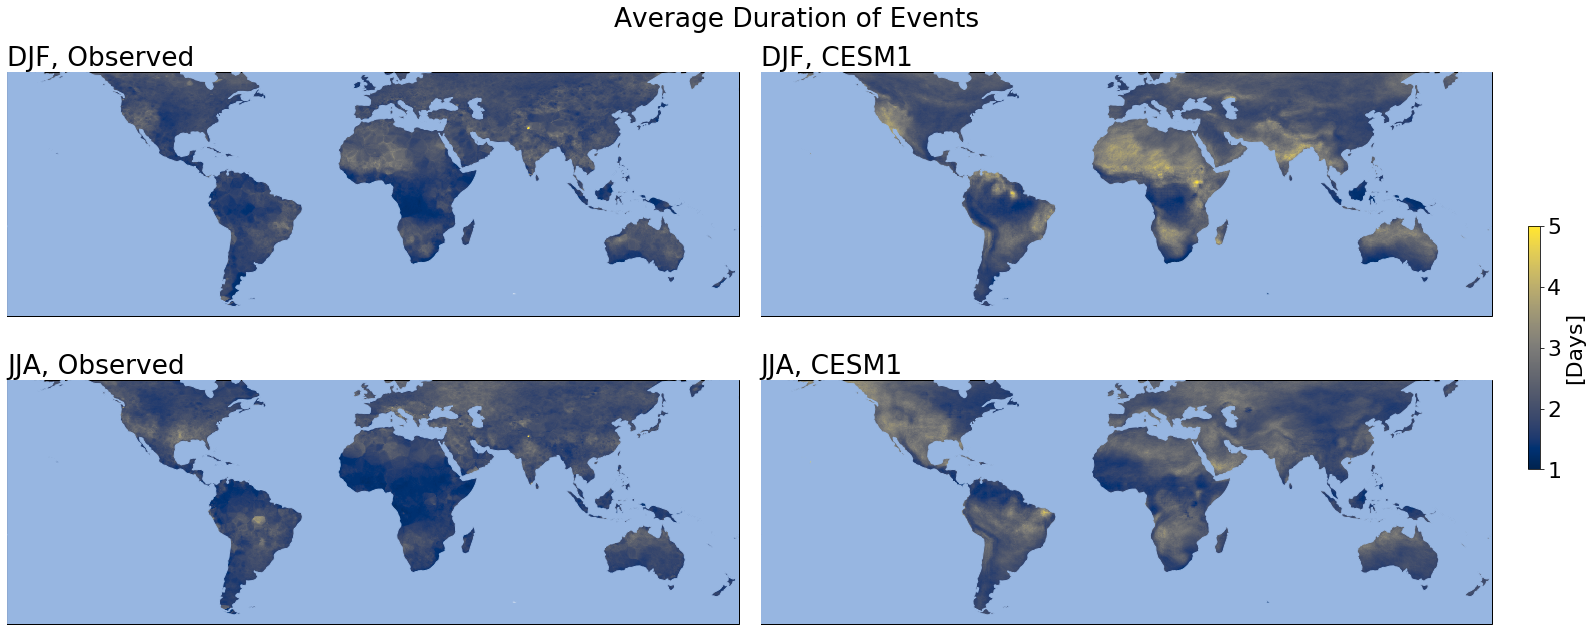

In [13]:
fig, ax = plt.subplots(figsize=(22,9), ncols=2, nrows=2, subplot_kw={'projection':ccrs.PlateCarree()}, constrained_layout=True)
aa = ax.ravel()
imgs = [aa[i].pcolormesh(lons, 
                         lats, 
                         v, 
                         transform=ccrs.PlateCarree(), 
                         cmap='cividis', vmin=1.0, vmax=5.0) 
        for i, v in enumerate([obs_djf_avg_dur, mdl_djf_avg_dur, obs_jja_avg_dur, mdl_jja_avg_dur])]
[a.add_feature(cartopy.feature.OCEAN, zorder=100) for a in aa]
[a.set_extent([-180, 180, -60, 60]) for a in aa]
aa[0].set_title("DJF, Observed", loc='left')
aa[1].set_title("DJF, CESM1", loc='left')
aa[2].set_title("JJA, Observed", loc='left')
aa[3].set_title("JJA, CESM1", loc='left')
cb = fig.colorbar(imgs[0], ax=aa, shrink=0.4)
cb.set_label("[Days]")
fig.suptitle("Average Duration of Events")
fig.savefig("/project/amp/brianpm/ams_poster_fig5.png", bbox_inches='tight')

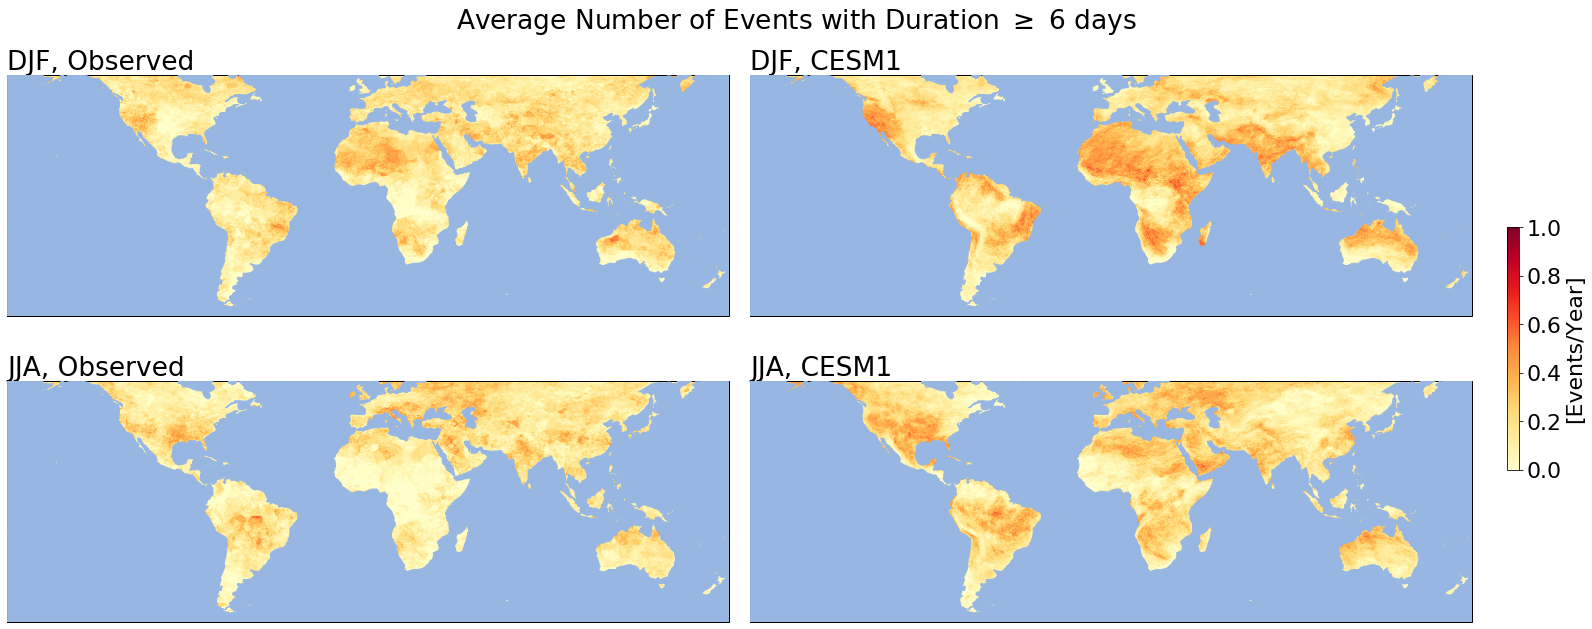

In [27]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(22,9), ncols=2, nrows=2, subplot_kw={'projection':ccrs.PlateCarree()}, constrained_layout=True)
aa = ax.ravel()
imgs = [aa[i].pcolormesh(lons, 
                         lats, 
                         v, 
                         transform=ccrs.PlateCarree(), 
                         cmap='YlOrRd', vmin=0.0, vmax=1.0) 
        for i, v in enumerate([obs_djf_avg_long, mdl_djf_avg_long, obs_jja_avg_long, mdl_jja_avg_long])]
[a.add_feature(cartopy.feature.OCEAN, zorder=100) for a in aa]
[a.set_extent([-180, 180,-60, 60]) for a in aa]
aa[0].set_title("DJF, Observed", loc='left')
aa[1].set_title("DJF, CESM1", loc='left')
aa[2].set_title("JJA, Observed", loc='left')
aa[3].set_title("JJA, CESM1", loc='left')
cb = fig.colorbar(imgs[0], ax=aa, shrink=0.4)
cb.set_label("[Events/Year]")
fig.suptitle("Average Number of Events with Duration $\geq$ 6 days")
fig.savefig("/project/amp/brianpm/ams_poster_fig6.png", bbox_inches='tight')

In [21]:
ds['initial_date'].min()

<xarray.DataArray 'initial_date' ()>
array('1979-01-01T00:00:00.000000000', dtype='datetime64[ns]')

In [22]:
np.datetime64('NaT')

numpy.datetime64('NaT')